# Outlier detection in time series using machine learning models
Notebook 03 splitting and pre-processing
___

### Table of Contents:
* [Introduction](#hading-1)
* [Pre-processing](#heading-2)
* [Split](#heading-3)
* [Export](#heading-4)

### Introduction <a class="anchor" id="heading-1"></a>

TODO

### Import libraries 


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime as dt

plt.rcParams.update({'font.size': 10})

### Functions 

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot


def decomposition_df(df, column, frequency='MS',aggregation_method='sum', type='additive'):
    '''
    Process a dataframe to decompose its time series data and add trend, seasonal, residual, and trend+seasonal columns.
    
    Parameters:
    - df: pandas DataFrame containing the data to be processed
    - column: the column to be processed in the dataframe
    - frequency: the frequency of the decomposition, default monthly 
        - D - daily
        - h- hourly
        - W- weekly 

        look here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    -aggregation_method: the method of the decomposition, default sum
        -mean
        -min
        -max


    -type: the used model in the decomposition, default = additive
        - multiplicative 
    
    
    Returns:
    - df_Frequency: the processed DataFrame with additional columns
    '''
    aggregation_func = getattr(pd.DataFrame, aggregation_method)
    df_Frequency=df[[column]].resample(frequency).apply(aggregation_func)
    decompositon= seasonal_decompose(df_Frequency[column], model=type)


    df_Frequency['Trend'] = decompositon.trend
    df_Frequency['Seasonal'] = decompositon.seasonal
    df_Frequency['Residual'] = decompositon.resid
    df_Frequency['Trend+Seasonal'] = df_Frequency['Seasonal'] + df_Frequency['Trend']

    return df_Frequency

In [28]:
def data_loading_and_set_index(df_name, base_path = '../data/'):
    '''
    loads the dataframe df from the base_path and set_the 'Start' column as the index in datetime format.

    df_name: expect a df Name for example Prices_FRA_hourly
    base_path default: '../data/' 

    return Prices_FRA_hourly
    '''
    
    file_path = f"{base_path}{df_name}.csv"
    df= pd.read_csv(file_path)
    if 'Unnamed: 0' in df.columns:
        df['Start'] = pd.to_datetime(df['Unnamed: 0'])
        df = df.drop(columns = 'Unnamed: 0')
        df = df.set_index('Start')
    else:
        df['Start'] = pd.to_datetime(df['Start'])
        df = df.set_index('Start')

    return df

In [29]:
def train_test_splitter(df, date = '2021-03-21 00:00:00'):
    '''
    takes a dataframe df and splits it at a custome date into df1, df2 as return
    '''
    df1 = df.loc[df.index <= date]
    df2 = df.loc[df.index > date]

    return df1, df2

### Import

In [30]:
Consumption = data_loading_and_set_index('Consumption')
Generation = data_loading_and_set_index('Generation')
Export_Import = data_loading_and_set_index('Export_Import')
Prices = data_loading_and_set_index('Prices')
Inflation_index = data_loading_and_set_index('Inflation_index')

In [31]:
co2_Prices = pd.read_csv('../data/co2_Prices.csv')
co2_Prices['Start'] = pd.to_datetime(co2_Prices['Date'])
co2_Prices = co2_Prices.drop(columns = 'Date')
co2_Prices = co2_Prices.set_index('Start')

In the end, we will follow two basic approaches. 

Approach no. 1 only refers to the price in our target region, i.e. only historical price data from Germany and Luxembourg is included in the forecast. 

Approach no. 2, on the other hand, includes all available data in the modelling. It will include generation, import-export and the price in other zones.

### Pre-processing <a class="anchor" id="heading-2"></a>

In [32]:
Prices.columns

Index(['Germany_Luxembourg', 'Belgium', 'France', 'Austria', 'Switzerland',
       'Czech_Republic', 'Germany_Luxembourg_adjusted', 'France_adjusted',
       'Belgium_adjusted', 'Austria_adjusted', 'Switzerland_adjusted',
       'Czech_Republic_adjusted', 'Germany_Luxembourg_co2_adjusted'],
      dtype='object')

In [33]:
Prices_GER_weekly_co2 = decomposition_df(Prices, 'Germany_Luxembourg_co2_adjusted', 'W', 'mean')

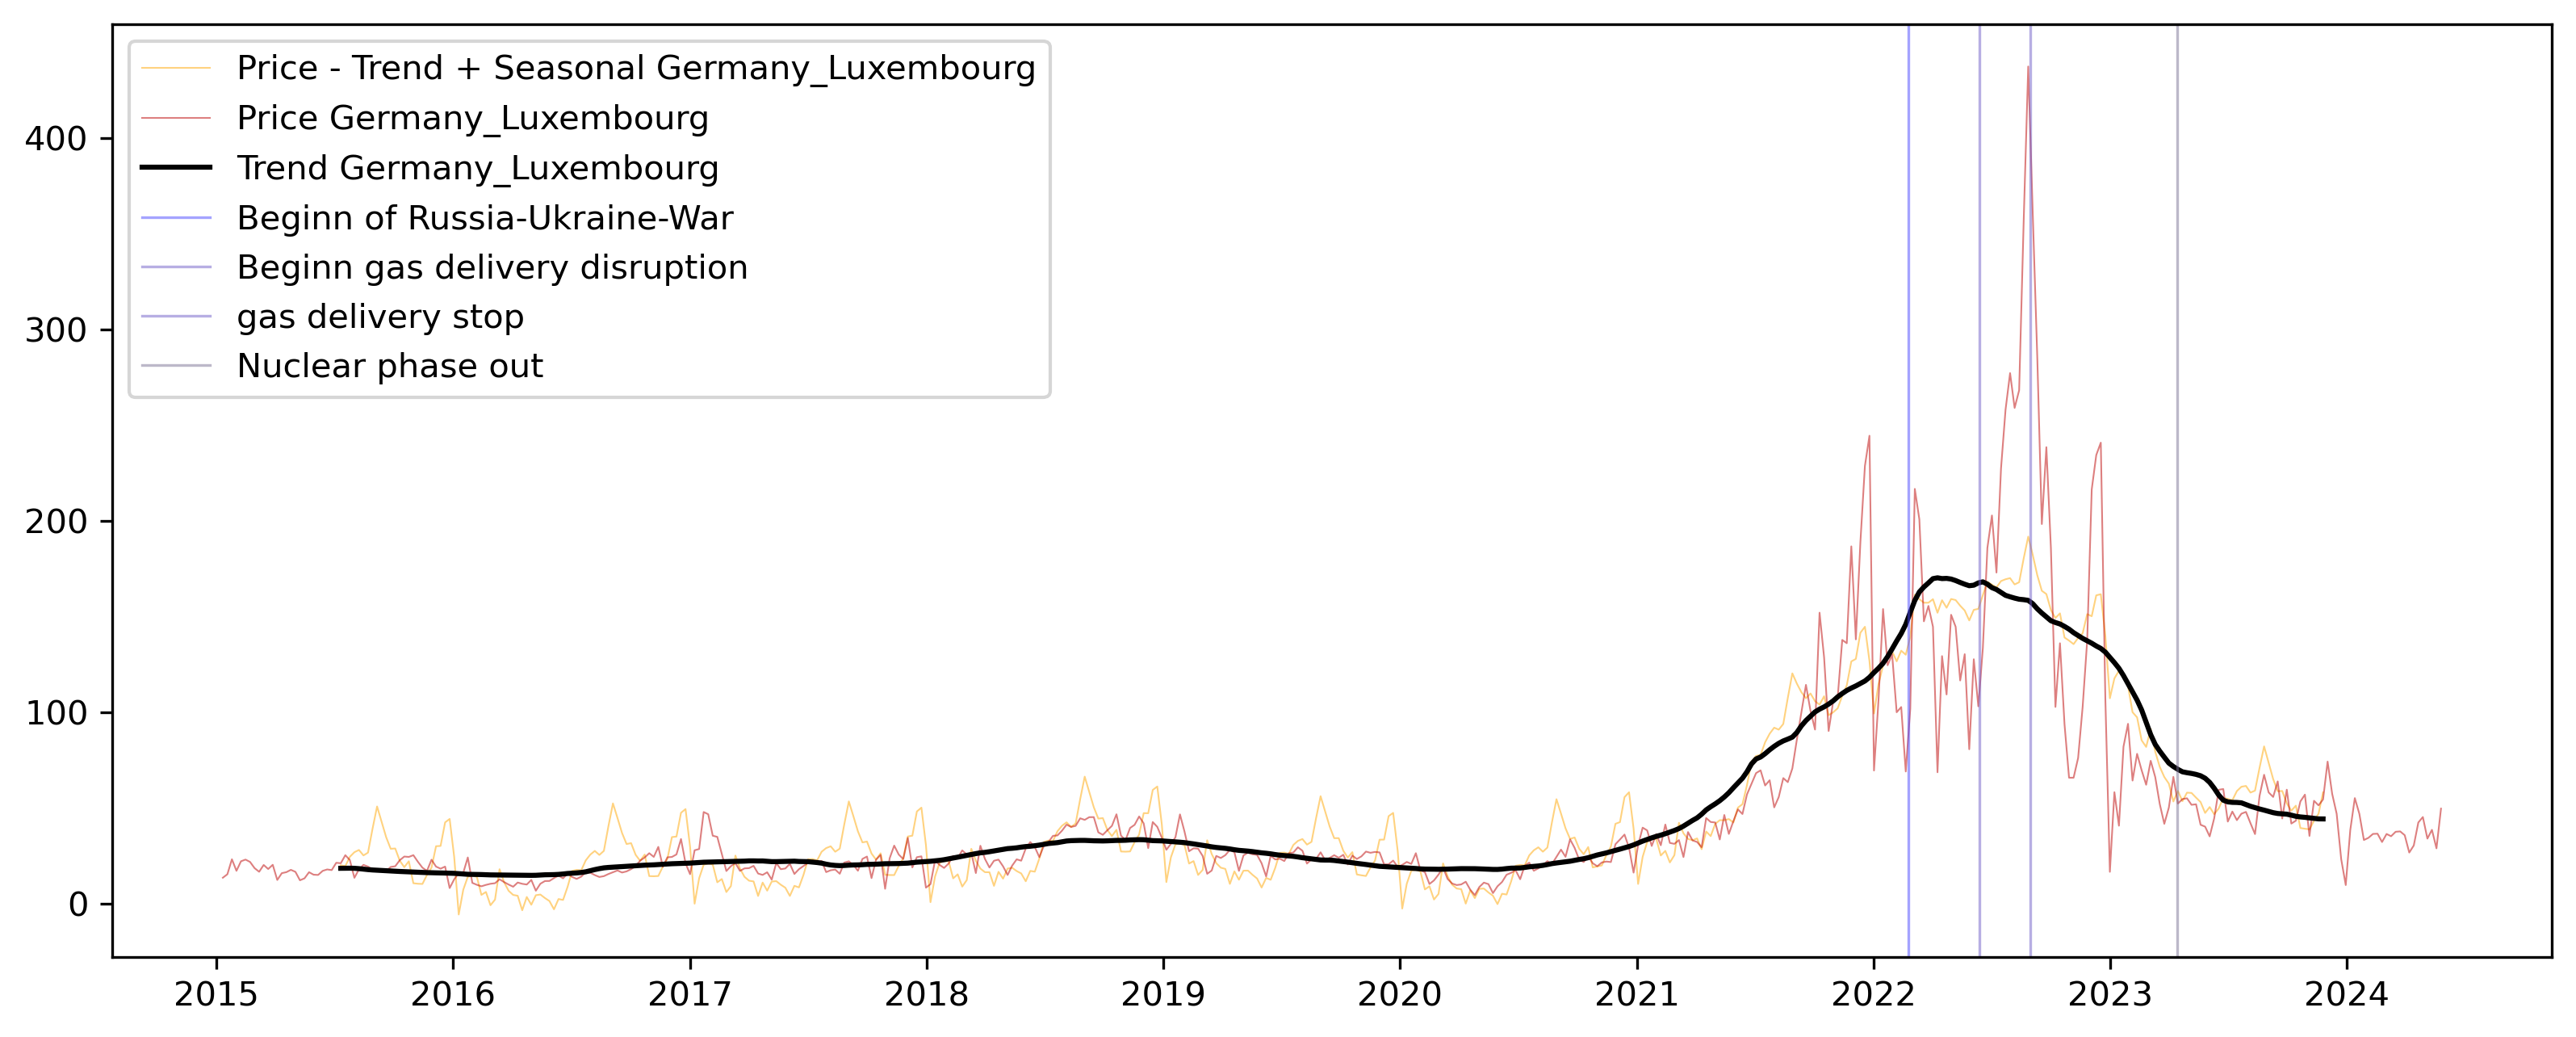

In [34]:
plt.figure(figsize= (13,5), dpi = 300)

plt.plot(Prices_GER_weekly_co2['Trend+Seasonal'], label = 'Price - Trend + Seasonal Germany_Luxembourg', color = '#ffa600',alpha = .5, linewidth = 0.5 )
plt.plot(Prices_GER_weekly_co2['Germany_Luxembourg_co2_adjusted'], label = 'Price Germany_Luxembourg',color='#bc0000', alpha = .5, linewidth = 0.5 )
plt.plot(Prices_GER_weekly_co2['Trend'], label = 'Trend Germany_Luxembourg',color='#000000')# ,alpha = .2, linewidth = 0.5 )


plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2022,8,31),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'gas delivery stop')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.legend()
plt.show()

In [35]:
Prices_GER_weekly_co2['Trend_Slope'] = Prices_GER_weekly_co2['Trend'].diff()

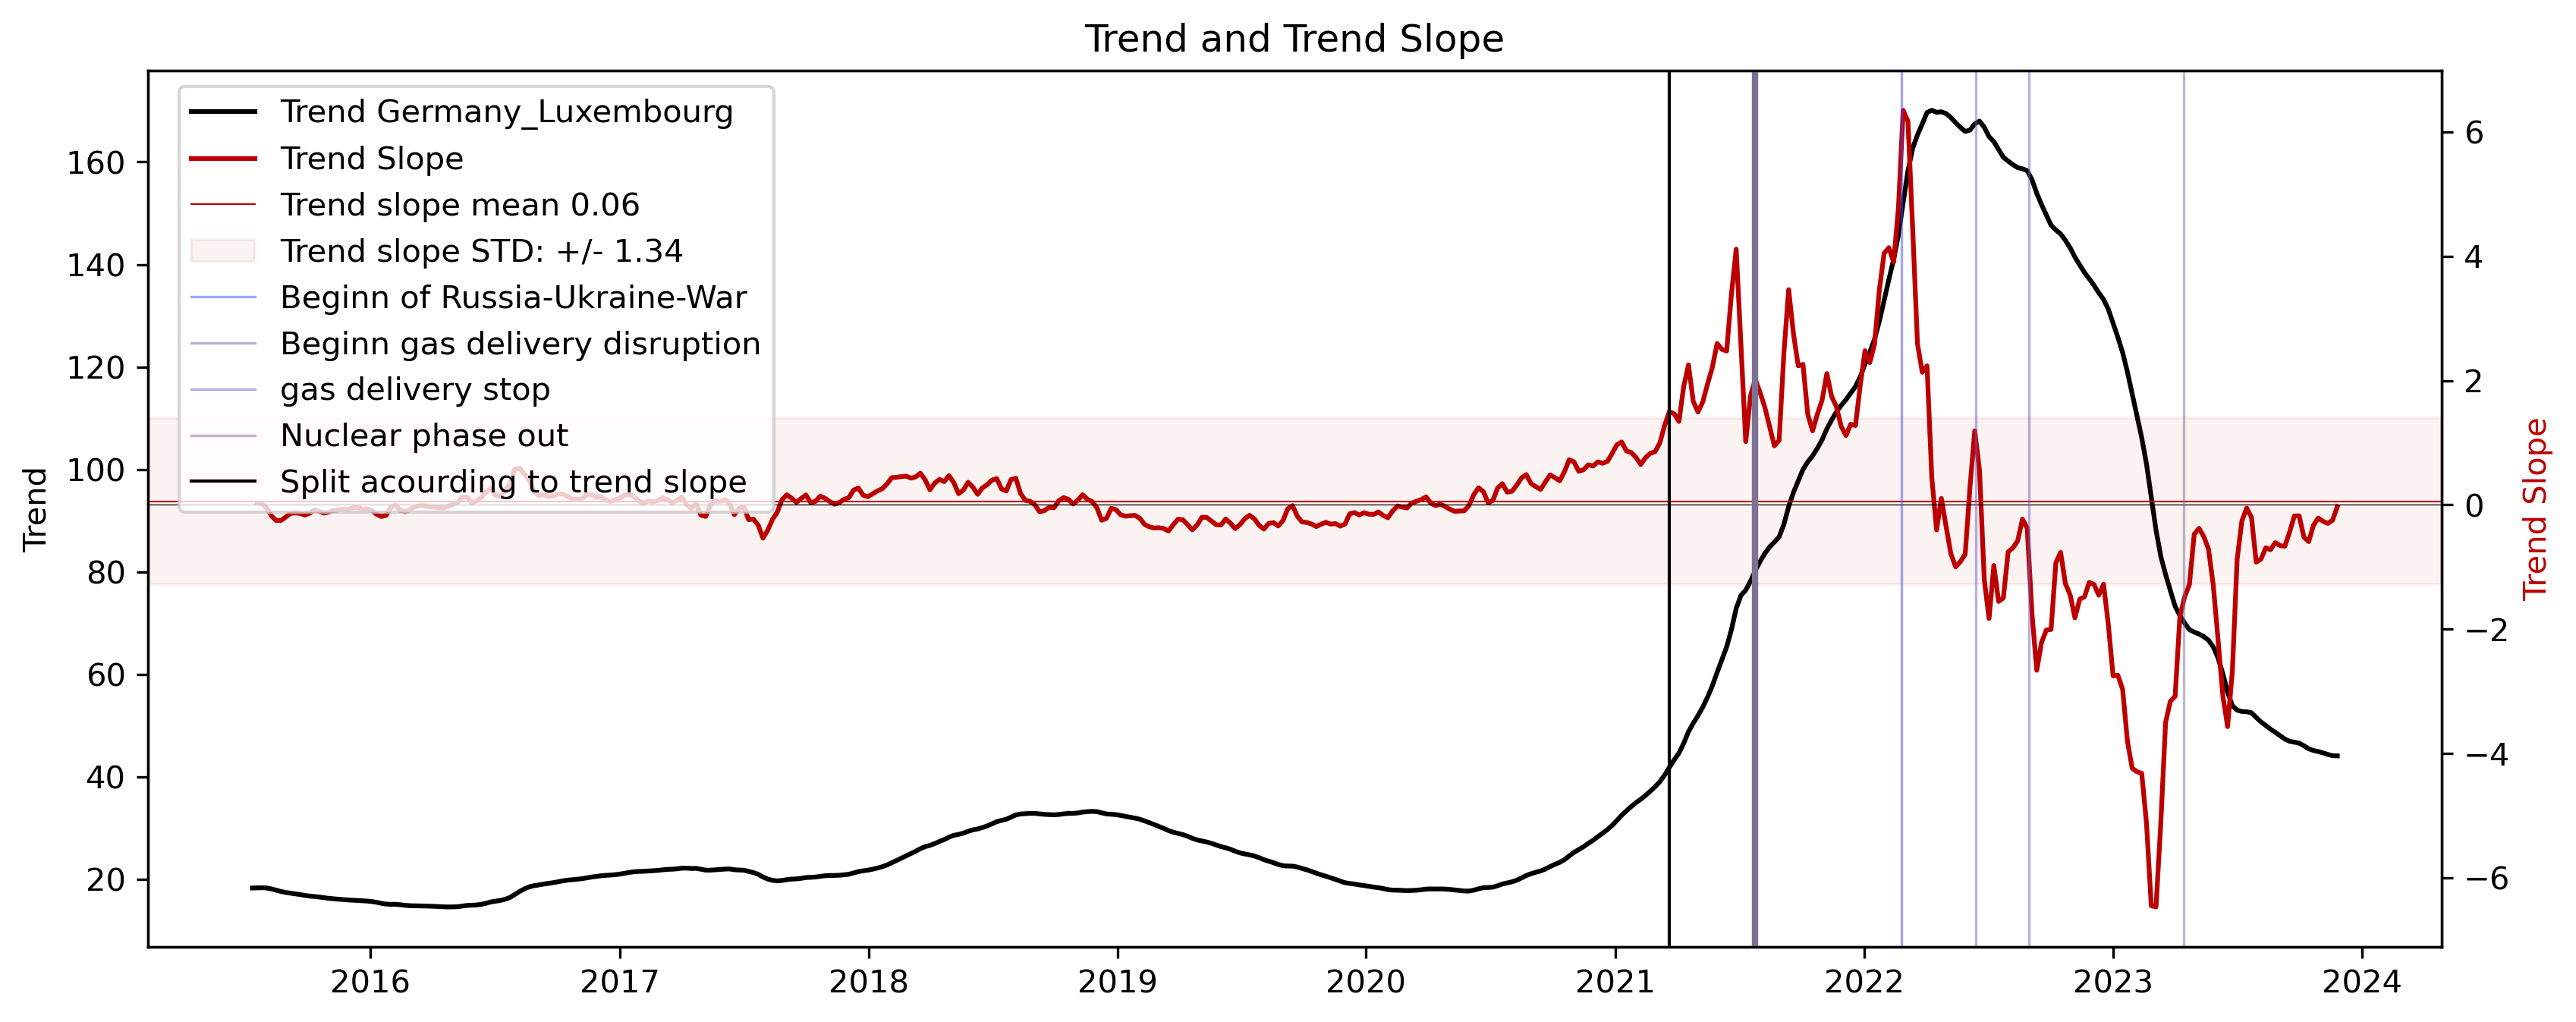

In [36]:
Trend_slope_std = Prices_GER_weekly_co2['Trend_Slope'].std()
Trend_slope_mean = Prices_GER_weekly_co2['Trend_Slope'].mean()


fig, ax1 = plt.subplots(figsize=(13, 5), dpi=300)


ax1.plot(Prices_GER_weekly_co2.index, Prices_GER_weekly_co2['Trend'], label='Trend Germany_Luxembourg', color='#000000')
ax1.set_ylabel('Trend', color='#000000')


ax2 = ax1.twinx()
ax2.plot(Prices_GER_weekly_co2.index, Prices_GER_weekly_co2['Trend_Slope'], label='Trend Slope', color='#bc0000')

ax2.axhline(y=Trend_slope_mean, color = '#bc0000', linewidth = 0.5, label = f'Trend slope mean {(Trend_slope_mean).round(2)}')
ax2.axhspan(ymin=Trend_slope_mean-Trend_slope_std,ymax=Trend_slope_mean+Trend_slope_std, alpha = 0.05, label = f'Trend slope STD: +/- {(Trend_slope_std).round(2)}',color = '#bc0000')

ax2.axhline(y=0, color = '#000000', linewidth = 0.3)
ax2.set_ylabel('Trend Slope', color='#bc0000')

plt.axvline(x=dt.datetime(2022,2,24),color = '#4a48ff', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
plt.axvline(x=dt.datetime(2022,8,31),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'gas delivery stop')
plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')





plt.axvline(x=dt.datetime(2021,3,21),color = '#000000', alpha = 1, linewidth = 1,  label = 'Split acourding to trend slope')
plt.axvline(x=dt.datetime(2021,7,25),color = '#7b7294', alpha = 1, linewidth = 2) #label = 'Split point 2 ? '

fig.legend(loc = 'upper left', bbox_to_anchor=(0.13, 0.88))
plt.title('Trend and Trend Slope')
plt.show()

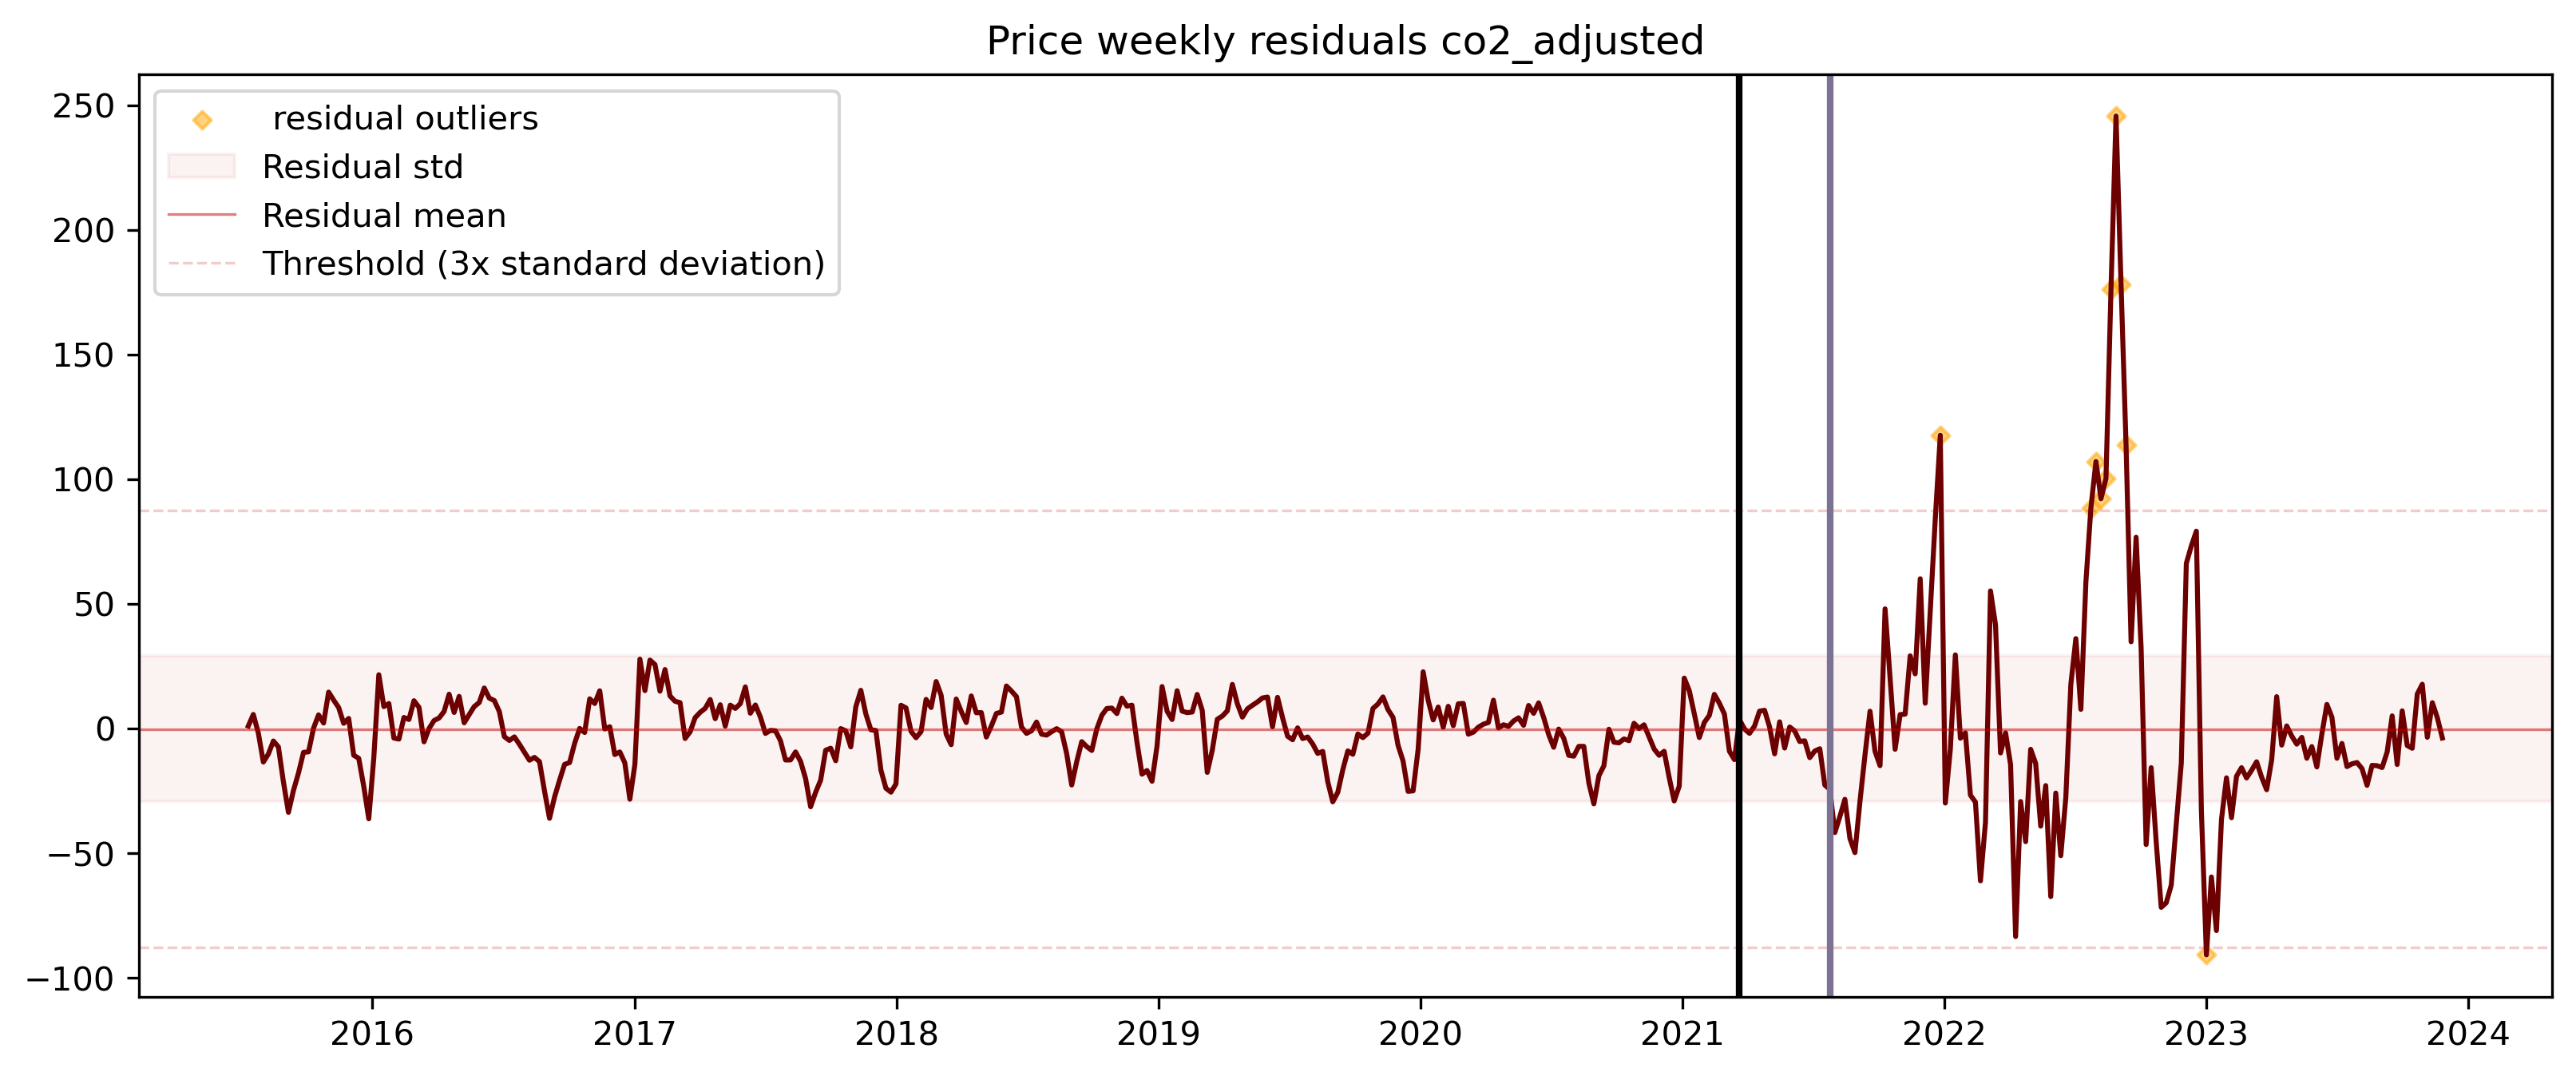

mean_Prices_GER_weekly_co2_residual: -0.2
std_Prices_GER_weekly_co2_residual: 29.18


In [37]:
mean_Prices_GER_weekly_co2_residual = np.mean(Prices_GER_weekly_co2['Residual'])
std_Prices_GER_weekly_co2_residual = np.std(Prices_GER_weekly_co2['Residual'])
threshold = std_Prices_GER_weekly_co2_residual*3

marker = Prices_GER_weekly_co2[['Residual']].loc[(Prices_GER_weekly_co2['Residual'] >=3*std_Prices_GER_weekly_co2_residual)|(Prices_GER_weekly_co2['Residual'] <=-3*std_Prices_GER_weekly_co2_residual)].sort_values('Residual', ascending = False)

plt.figure(figsize= (13,5), dpi = 300)

plt.plot(Prices_GER_weekly_co2['Residual'], color = '#6d0000')
plt.scatter(x=marker.index, y= marker['Residual'], color = '#ffa600',alpha = 0.5, s=14,  marker ='D' , label = ' residual outliers')
plt.axhspan(ymin=-std_Prices_GER_weekly_co2_residual,ymax=std_Prices_GER_weekly_co2_residual, alpha = 0.05, label = 'Residual std',color = '#bc0000')
plt.axhline(y=mean_Prices_GER_weekly_co2_residual,color = '#bc0000', alpha = .5, linewidth = .8,  label = 'Residual mean')

plt.axhline(y=threshold,color = '#bc0000', alpha = .2, linewidth = .8,  label = 'Threshold (3x standard deviation)', linestyle = '--')
plt.axhline(y=-threshold,color = '#bc0000', alpha = .2, linewidth = .8, linestyle = '--')



plt.axvline(x=dt.datetime(2021,3,21),color = '#000000', alpha = 1, linewidth = 2) #label = 'Split acourding to trend slope'
plt.axvline(x=dt.datetime(2021,7,25),color = '#7b7294', alpha = 1, linewidth = 2) #label = 'Split point 2 ? '


plt.legend()
plt.title('Price weekly residuals co2_adjusted')
plt.show()
print(f'mean_Prices_GER_weekly_co2_residual: {(mean_Prices_GER_weekly_co2_residual).round(2)}')
print(f'std_Prices_GER_weekly_co2_residual: {(std_Prices_GER_weekly_co2_residual).round(2)}')


In [38]:
Prices_GER_weekly_co2[['Residual']].loc[(Prices_GER_weekly_co2['Residual'] >=3*std_Prices_GER_weekly_co2_residual)|(Prices_GER_weekly_co2['Residual'] <=-3*std_Prices_GER_weekly_co2_residual)].sort_index(ascending = True)

,Residual
Start,
2021-12-26,117.644090
2022-07-24,88.589672
2022-07-31,107.105137
2022-08-07,92.220328
2022-08-14,100.307436
2022-08-21,176.303032
2022-08-28,245.613287
2022-09-04,178.232689
2022-09-11,113.665064


### Split <a class="anchor" id="heading-3"></a>

In [39]:
date_range_change = '2021-03-21 00:00:00'
date_range_change_dt = dt.datetime.strptime(date_range_change, '%Y-%m-%d %H:%M:%S')

In [40]:
Prices_train, Prices_test = train_test_splitter(Prices, date = date_range_change)
Consumption_train, Consumption_test = train_test_splitter(Consumption, date = date_range_change)
Generation_train, Generation_test = train_test_splitter(Generation, date = date_range_change)
Export_Import_train, Export_Import_test = train_test_splitter(Export_Import, date = date_range_change)

### Export <a class="anchor" id="heading-4"></a>

In [41]:
Prices_train.index.max()

Timestamp('2021-03-21 00:00:00')

In [42]:
Prices_test.index.min()

Timestamp('2021-03-21 00:15:00')

In [43]:
Consumption_test.to_csv('../data/Consumption_test.csv', index = True)
Consumption_train.to_csv('../data/Consumption_train.csv', index = True)
Prices_test.to_csv('../data/Prices_test.csv', index = True)
Prices_train.to_csv('../data/Prices_train.csv', index = True)
Generation_test.to_csv('../data/Generation_test.csv', index = True)
Generation_train.to_csv('../data/Generation_train.csv', index = True)
Export_Import_test.to_csv('../data/Export_Import_test.csv', index = True)
Export_Import_train.to_csv('../data/Export_Import_train.csv', index = True)

___
#### Conclusion / Next Steps

TODO

___